# Modeling
The aim of this file is to train different models with different techniques. The main purpose is to prove whether using techniques like SMOTE and Undersampling would help in enhancing the predictive power of the models or not. The classes are imbalanced with a ratio 1:25. Models should be saved so it can be loaded in the evaluation file to confirm or disprove the assumption, or to answer the question.

## Mounting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem

/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem


## Loading Libraries & Datasets

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import random
import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
TrainDataFilepath = '../TrivagoRecommenderSystem1/Datasets/clean_data/Sets/train.csv'
TrainData = pd.read_csv(TrainDataFilepath)

# declaring features and label
features = TrainData.drop(columns=['session_id', 'item_id', 'clickout']).columns.tolist()
label = ['clickout']

## Features Correlation

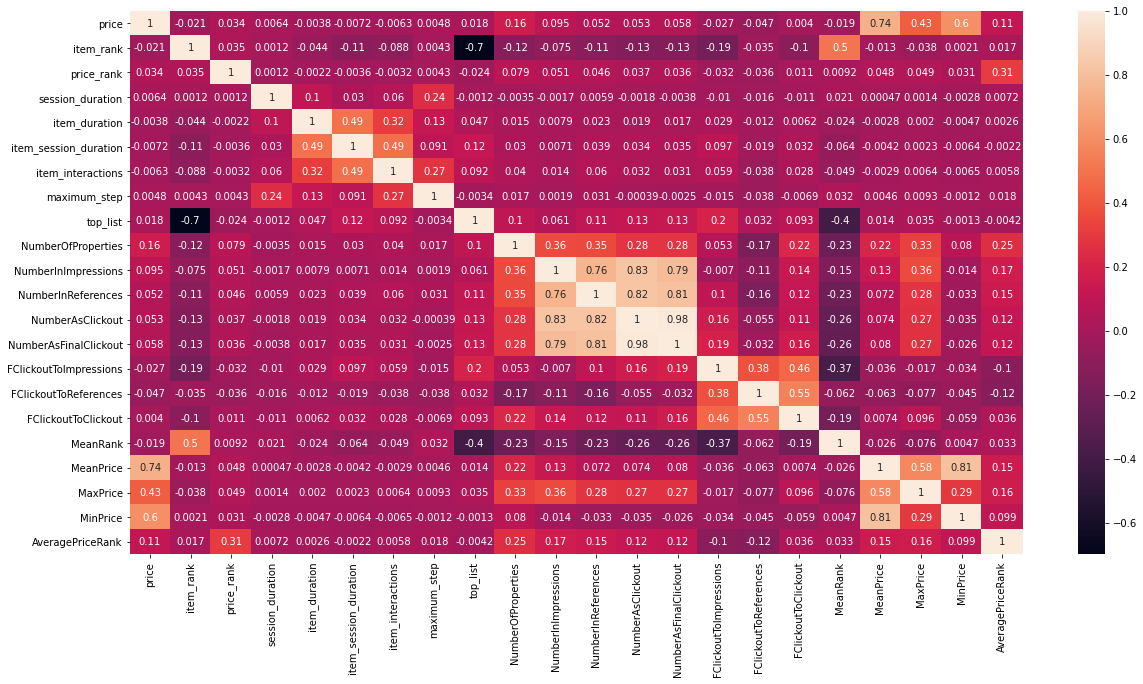

In [0]:
CorrMatrix = TrainData[features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.show()

* item_rank has a strong negative correlation with top_list, that's normal since it is treated as continous variable while it should be treated as a nominal value of wether or not the item is on top of the list already.  
* NumberInImpressions & NumberInReferences have strong correlations with each other's, and also with NumberAsClickout. So, they should be dropped.
*MeanPrice and MinPrice have strong correlations with Price, so they need to be dropped as well.

In [0]:
FeaturesToDrop = ['NumberInImpressions', 'NumberInReferences', 'MeanPrice', 'MinPrice']
for feature in FeaturesToDrop:
  features.remove(feature)

X_train = TrainData[features]
y_train = TrainData[label]

## SelectKBest

In [6]:
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))   #print 8 best features

                    Specs         Score
4           item_duration  2.840552e+08
6       item_interactions  1.272761e+07
10       NumberAsClickout  3.023488e+06
11  NumberAsFinalClickout  2.303099e+06
1               item_rank  2.095303e+06
0                   price  6.917975e+05
5   item_session_duration  6.014721e+05
8                top_list  5.040456e+05


Scores are high which means the features are relevant to the output, so all of the features will be taken in modeling at first, and then by removing the least important features, the performance of the model will be captured.

In [0]:
features = featureScores.nlargest(8,'Score').Specs.tolist()
X_train = TrainData[features]
y_train = TrainData[label]

TrainData is ready for processing and modeling, while validation and test sets still need to be engineered. There is a ready function that will transform sets into the same form of TrainData.

## Scaling Features

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
])

from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
("num", num_pipeline, list(X_train)) 
])                              

X_train_scaled = full_pipeline.fit_transform(X_train)

## Models

In [0]:
def print_results(results):
  print('Best Prams: {}\n'.format(results.best_params_))

  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
  return

from sklearn.metrics import label_ranking_average_precision_score

#function is from this repo https://gist.github.com/bwhite/3726239
def mean_reciprocal_rank(rs):
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def MRR(estimator, X, y):
  probability = estimator.predict_proba(X)[:, 1]
  y['probability'] = probability
  X_reset = X.reset_index()
  y['session_id'] = X_reset['session_id'].tolist()
  RecommendationsDF = y.groupby(['session_id'], sort=False).apply(lambda x: (x.sort_values('probability', ascending=False)))
  clickout_rank = RecommendationsDF.clickout
  clickout_rank = clickout_rank.reset_index().groupby('session_id', sort=False).clickout.apply(list).values.tolist()
  return mean_reciprocal_rank(clickout_rank)

## RandomizedSearchCV
I have used in another vesion Randomized Search Cross Validation with a customer scoring function which was Mean Reciprocal Rank (see the above cell) in order to get the best hyper-parameters. The main problem was Over Optimism. The models were too good to be true, and that screwed picking the best hyper parameters.

## Validation Set Hyper-paramter Tuning
For the sake of simplification, I trained multiple models, and I validate which parameters are the best to use. The following used paramters are picked based on their well performance amongst others.

###Without Resampling

#### Logistic Regression

In [16]:
lr = LogisticRegression(C=0.01)
lr.fit(X_train_scaled, y_train.values.ravel())
joblib.dump(lr, './models/LR_model.pkl')

['./models/LR_model.pkl']

#### Random Forest

In [18]:
rf = RandomForestClassifier(max_depth=1, n_estimators=150, n_jobs=-1)
rf.fit(X_train_scaled, y_train.values.ravel())
joblib.dump(rf, './models/RF_model.pkl')

['./models/RF_model.pkl']

#### XGBoost

In [19]:
gb = GradientBoostingClassifier(max_depth=1, n_estimators=150, learning_rate=0.01)
gb.fit(X_train_scaled, y_train.values.ravel())
joblib.dump(gb, './models/XGB_model.pkl')

['./models/XGB_model.pkl']

### With SMOTE

In [20]:
sm = SMOTE(ratio=0.5, random_state=0, n_jobs=-1)
X_SM, y_SM = sm.fit_sample(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Logistic Regression

In [21]:
lr = LogisticRegression(C=0.001)
lr.fit(X_SM, y_SM)
joblib.dump(lr, './models/LR_SMOTE.pkl')

['./models/LR_SMOTE.pkl']

#### Random Forest

In [22]:
rf = RandomForestClassifier(max_depth=1, n_estimators=100, n_jobs=-1)
rf.fit(X_SM, y_SM)
joblib.dump(rf, './models/RF_SMOTE.pkl')

['./models/RF_SMOTE.pkl']

#### XGBoost

In [23]:
gb = GradientBoostingClassifier(max_depth=1, n_estimators=200, learning_rate=0.01)
gb.fit(X_SM, y_SM)
joblib.dump(gb, './models/XGB_SMOTE.pkl')

['./models/XGB_SMOTE.pkl']

### With Undersampling

In [24]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=1, n_neighbors=3, random_state=0, n_jobs=-1)
X_usample, y_usample = nm.fit_resample(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Logistic Regression

In [25]:
lr = LogisticRegression(C=10)
lr.fit(X_usample, y_usample)
joblib.dump(lr, './models/LR_usample.pkl')

['./models/LR_usample.pkl']

#### Random Forest

In [26]:
rf = RandomForestClassifier(max_depth=1, n_estimators=150, n_jobs=-1)
rf.fit(X_usample, y_usample)
joblib.dump(rf, './models/RF_usample.pkl')

['./models/RF_usample.pkl']

#### XGBoost

In [27]:
gb = GradientBoostingClassifier(max_depth=1, n_estimators=100, learning_rate=0.1)
gb.fit(X_usample, y_usample)
joblib.dump(gb, './models/XGB_usample.pkl')

['./models/XGB_usample.pkl']

## Conclusion
I used SMOTE and Undersampling techniques in a trial of making the predictive power of the model better. In the evaluation file, the results can show if this assumption is true or not.